# Hands On #6 - Balancing Cart Pole w/DQN

## Goal:
* Implement Deep Q-Learning for CartPole
    * No digitization
    * Handle continuous state

## Steps:
1. Program Deep Q Learning
2. Intro to pytorch
3. Metrics to solve Cart Pole
4. Plot Values

Reference : 
* My solution for the DQN https://github.com/xsankar/DQN_Navigation/blob/master/Navigation-v2.ipynb

## Notebook Organization:

### The notebook has 3 parts :

* __Part 1__ : Defines the classes, initiates the environment and so forth. It sets up all the scaffolding needed
* __Part 2__ : Explore and Learn - it performs the DQN Reinforcement Learning. It also saves the best model
* __Part 3__ : Run saved model

## Part 1 - Definitions & Setup
----

### 1. Install the required packages

* No esoteric requirements
* You can run them without docker
* pip install -r requirements.txt
* Requirements
 * python 3.6, pytorch, openAI gym, numpy, matplotlib
 * anaconda is easier but not needed
 * Miniconda works fine

### 2. Define imports

python 3, numpy, matplotlib, torch, gym

In [1]:
# General imports
import gym
import PIL # for in-line display of certain environments

import sys
import numpy as np
import random
from collections import namedtuple, deque, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2.1. Global Constants and other variables

In [2]:
# Constants Definitions
BUFFER_SIZE = 512 # int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Number of neurons in the layers of the Q Network
FC1_UNITS = 16
FC2_UNITS = 8
FC3_UNITS = 4
# Store models flag. Store during calibration runs and do not store during hyperparameter search
STORE_MODELS = False

### Work Area

In [3]:
# Work area to quickly test utility functions
import math
import time
from datetime import datetime, timedelta
'''
start_time = time.time()
time.sleep(10)
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
'''
print(math.radians(12))
print(math.radians(-12))

0.20943951023931956
-0.20943951023931956


In [4]:
# import gym, PIL
# env = gym.make('CartPole-v0')
# array = env.reset()
# PIL.Image.fromarray(env.render(mode='rgb_array'))

### 3.0 Create instance & Explore

In [5]:
import gym
env = gym.make('CartPole-v0')
env.reset()
# array = env.reset()
# ** render doesn't work reliably on a server. Uncomment when running ** locally **
# env.render()
# PIL.Image.fromarray(env.render(mode='rgb_array'))

/miniconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([-0.00207654,  0.01987368, -0.01300494,  0.01678067])

### This what it will look like
### We don't need the render(). We run it on headless mode and inspect the results
<img src="CartPole_Render.jpg">

### 3.1 Examine the State and Action Spaces

* The state space is continuous, with an observation space of 4 
    * {x,$\dot{x}$,$\theta$, theta_dot}
        * Cart Position,  Cart Velocity, Pole Angle, Pole Velocity at tip
        * The angle, probably, is in radians

The action space, on the contrary is simple viz. 0 = Left, 1 = Right

In [6]:
print(env.observation_space)
print(env.action_space)
act_space = [i for i in range(0,env.action_space.n)]
print(act_space)
# env.unwrapped.get_action_meanings() # AttributeError: 'FrozenLakeEnv' object has no attribute 'get_action_meanings'
print('[ 0 = Left, 1 = Right ]')

Box(4,)
Discrete(2)
[0, 1]
[ 0 = Left, 1 = Right ]


In [7]:
print(dir(env))
print(dir(env.unwrapped))
# To see what functions and variables are availabe
print('States = ',env.unwrapped.observation_space)
print('Actions = ',env.unwrapped.action_space)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_elapsed_seconds', '_elapsed_steps', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_past_limit', 'action_space', 'class_name', 'close', 'compute_reward', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'action_space', 'cl

In [8]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### 4. Test the environment with Random Action

In [9]:
for i_episode in range(3):
    state = env.reset()
    tot_reward = 0
    steps = 0
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        print('[',state,']','->', action,' : [',next_state,']', 'R=',reward)
        # env.render() # Uncomment when running ** locally **. But no need, headless operation is fine
        tot_reward += reward
        steps += 1
        if done:
            print('Episode {:d} finished after {:d} steps with a Total Reward = {:.0f}'.
                  format(i_episode+1,steps, tot_reward))
            break
        else:
            state = next_state
# Pole angle +/-12 degrees, Cart Pos +/- 2.4 or 200 steps
# Cart Pos, Velocity, Pole Angle, Velocity
# 12 degrees = .2094 radians

[ [-0.01130514  0.01678494  0.03270756  0.04122328] ] -> 0  : [ [-0.01096944 -0.17879039  0.03353202  0.34404369] ] R= 1.0
[ [-0.01096944 -0.17879039  0.03353202  0.34404369] ] -> 1  : [ [-0.01454525  0.01583888  0.0404129   0.06212045] ] R= 1.0
[ [-0.01454525  0.01583888  0.0404129   0.06212045] ] -> 1  : [ [-0.01422847  0.2103588   0.04165531 -0.21754304] ] R= 1.0
[ [-0.01422847  0.2103588   0.04165531 -0.21754304] ] -> 0  : [ [-0.0100213   0.0146669   0.03730445  0.08798331] ] R= 1.0
[ [-0.0100213   0.0146669   0.03730445  0.08798331] ] -> 1  : [ [-0.00972796  0.20923483  0.03906411 -0.19270057] ] R= 1.0
[ [-0.00972796  0.20923483  0.03906411 -0.19270057] ] -> 1  : [ [-0.00554326  0.40377681  0.0352101  -0.472809  ] ] R= 1.0
[ [-0.00554326  0.40377681  0.0352101  -0.472809  ] ] -> 1  : [ [ 0.00253227  0.59838425  0.02575392 -0.75418959] ] R= 1.0
[ [ 0.00253227  0.59838425  0.02575392 -0.75418959] ] -> 1  : [ [ 0.01449996  0.79314185  0.01067013 -1.0386583 ] ] R= 1.0
[ [ 0.01449996  

## The Algorithms

## Deep Q Learning
### Let us implement a decent Deep Q-Learning Algorithm
<img src='DQN_Alg.png'>

The major components of the algorithm are:
1. `A function approximator` implemented as a Deep Neural Network whih consists of fully connected layers. The function approximator learns the Q values for all the actions for a state space. The cartpole environment has a state space of 4 and an action space of 2. So out network has an inputsize of 4 and an output size of 2. It is a simple network.
2. `Experience replay buffer` - in order to train the network we take actions and then store the results in the replay buffer. The replay buffer is a circular buffer and it has methods to sample a random batch
3. `The Agent` brings all of the above together. It interacts with the environment by taking actions based on a policy, collects rewards and the observation feedback, then stores the experience in the replay buffer and also initiates a learning step on the Q Network.

### The Agent Architecture
#### The agent has 3 main components viz:
1. The DQN Orchestrator which interacts with the environment by taking actions and then unpacking the returned package to rewards, state space et al.
2. It also has to do housekeeping like tracking scores, store high performant models and check when the problem is solved
3. The 3rd component is the most interesting one, which gives the agent the capability to select right actions that maximize long term rewards
 * The fundamental unit is the Q value, which is the total expected reward, discounted for the future actions
 * The Q value is represented as Q(s,a) i.e. q values for all states for a state. In our case the dimensionality of the state is 4 and 2 actions are possible.
 * One method is to store all the Q-values in a dictionary with the state and action as key.
 * Another important concept is the policy i.e. the strategy to choose an action at a given state. We follow the ε-greedy policy i.e. for a probability of ε, we choose a random action and choose the action that maximizes the total reward otherwise.
 * So, if we have all the Q values in a table, we can search the actions for every state and then choose the action based on the ε-greedy policy. But as the state space becomes larger or even continuous, this table becomes unmanageable and resource consuming even impossible.
 * Function Approximator – Instead of the Q Table, we can train a function approximator which then can give us the q-value for a given state-action pair.
 * The function approximator in the DQN algorithm is a neural network, which gives a state returns the q-values for all the actions. This approach is better because, otherwise we need to run the inferencing for each of the action at every state
  * Now the challenge is how to train the network. There a few points to explore.
   * First is data. Usually the Reinforcement Learning problems involve a sequence of actions and so the Q values are correlated. So then learning run samples from a cache of State-Action-Reward tuple called the experience replay. This gives the network uncorrelated data to learn from. The experience replay buffer is a circular cache
  * Second is the training algorithm –we use the Fully Connected Neural Networks and train them using SGD (Stochastic Gradient Descent). The actual implementation uses the Adam optimizer. The training algorithm is succinctly captured in the following figure from Udacity.
  <img src="DQN_sgd.png">
  * In the above diagram, we have no way of getting the target yj. Interestingly this value is obtained from a target network that is exactly same as the expected value network, but updated less frequently. In the actual implementation, it is updated using the exponential decaying technique with the decay constant 𝛕 = 0.001.

In [10]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units = FC1_UNITS, fc2_units = FC2_UNITS, 
                 fc3_units = FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcx_units : Number of units in each layer
            ToDo : It is a little klugy, as the network is built manually layer-by-layer.
                Should take in a list fc_units and then dynamically build the network
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        # self.fc2 = nn.Linear(fc1_units,fc2_units)
        # self.fc3 = nn.Linear(fc2_units,fc3_units)
        # self.fc4 = nn.Linear(fc3_units,action_size)
        self.fc4 = nn.Linear(fc1_units,action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        #
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [12]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.1):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # compute and minimize the loss
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + gamma * Q_targets_next * (1 - dones)
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        # Compute Loss
        loss = F.mse_loss(Q_expected,Q_targets)
        
        #Minimize Loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# 1.6. Instantiate an agent

The state space and the action space dimensions come from the environment

In [13]:
agent = Agent(state_size=state_size, action_size=action_size, seed=42)
print(agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)


## Part 2 - Learn & Train
-----

### 2.1. DQN Algorithm

Define the DQN Algorithm. Once we have defined the foundations (network, buffer, agent and so forth), the DQN is relatively easy. It has a few responsibilities:
1. Orchastrate the episodes calling the appropriate methods
2. Display a running commentry of the scores and episode count
3. Check the success criterion for solving the environment i.e. if running average is > 13 and print the episode count
4. Store the model with the maximum score
5. Keep track of the scores for analytics at the end of the run

In [14]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    has_seen_195 = False
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()         # reset the environment
        score = 0
        max_steps = 0
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action) # send the action to the environment
            #
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            max_steps += 1
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
              format(i_episode, np.mean(scores_window),max_steps,eps,max_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
                  format(i_episode, np.mean(scores_window),max_steps,eps,max_score))
        if (np.mean(scores_window)>=195.0) and (not has_seen_195):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.\
                  format(i_episode-100, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            has_seen_195 = True
            break # early stop gives perfect score during testing !!
            # To see how far it can go we can comment the break. But it didn't work out for me.
        # Store the best model if desired
        if STORE_MODELS:
            if np.mean(scores_window) > max_score:
                max_score = np.mean(scores_window)
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                # print(' .. Storing with score {}'.format(max_score))
        if score > max_score:
            max_score = score
    return scores

### 2.2. The actual training Run

1. Run the DQN
2. Calculate and display end-of-run analytics viz. descriptive statistics and a plot of the scores

Episode : 100	Average Score : 22.92	Max_steps : 26	eps : 0.951	Max.Score : 71.000
Episode : 200	Average Score : 20.21	Max_steps : 15	eps : 0.905	Max.Score : 80.000
Episode : 300	Average Score : 21.73	Max_steps : 12	eps : 0.861	Max.Score : 93.000
Episode : 400	Average Score : 22.34	Max_steps : 16	eps : 0.819	Max.Score : 93.000
Episode : 500	Average Score : 22.72	Max_steps : 10	eps : 0.779	Max.Score : 97.000
Episode : 600	Average Score : 26.09	Max_steps : 37	eps : 0.741	Max.Score : 99.000
Episode : 700	Average Score : 30.28	Max_steps : 18	eps : 0.705	Max.Score : 99.000
Episode : 800	Average Score : 30.64	Max_steps : 25	eps : 0.670	Max.Score : 99.000
Episode : 900	Average Score : 46.54	Max_steps : 148	eps : 0.638	Max.Score : 158.000
Episode : 1000	Average Score : 72.23	Max_steps : 101	eps : 0.606	Max.Score : 168.000
Episode : 1100	Average Score : 75.40	Max_steps : 40	eps : 0.577	Max.Score : 200.0000
Episode : 1200	Average Score : 93.07	Max_steps : 200	eps : 0.549	Max.Score : 200.000
Episo

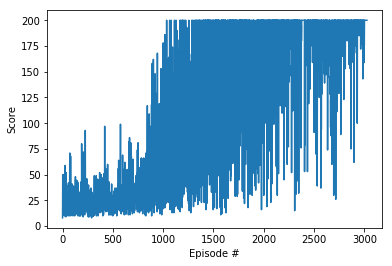

QNetwork(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)
Max Score 200.000000 at 1035
Percentile [25,50,75] : [ 31. 128. 200.]
Variance : 5854.559


In [15]:
start_time = time.time()
scores = dqn(n_episodes=5000,eps_end=0.01, eps_decay=0.9995) 
env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print(agent.qnetwork_local)
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

### Sample Run
#### Usually solves in ~4000 steps. 
#### It can do it in ~2400, but misses and unlearns
---
<img src="DQN_Solution.png">

## Part 3 : Test - Run a stored Model or test the current model

### Note
Here we are saving and loading the state dict, because we have access to the code.

- `torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')`
- `agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

The best way to save and load model, to be used by 2 distinct and separate entities is to :
- `torch.save(model, filepath)`; 
- Then later, `model = torch.load(filepath)`

In [16]:
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

### Points to Ponder
1. There is a form-fit equilibrium for every Deep Learning problem
2. I tried with a replay buffer of 100,000 and a network FC16-FC8-FC4-FC2
    * This couldn't find it's way around even after 100,000 episodes. It would just meander !
3. Reduced the buffer to 512, minibatch size = 64 (as before) and a tiny network FC16-FC2
    * Worked 1st time, solved the environment in 2582 episodes
    * I had set the number of episodes as 5,000. The network then was able to get a score of only ~123 during the test below.
4. The env cuts off after 200 episodes. So we can't get a score higher than 200
5. An early stop gives perferct 200 in the test below !! 
    * We have to assume that the network did learn a trick or two !!
    * And no digitization and the network can handle continuous state space (for co ntinuous action soace we need DDPG!)
<img src="Confidence.png">

## Test our Q network

In [17]:
scores=[]
for i in range(100): # 10 episodes
    state = env.reset()                                   # reset the environment
    score = 0                                             # initialize the score
    while True:
        action = agent.act(state)                         # select an action
        next_state, reward, done, info = env.step(action) # send the action to the environment
        score += reward                                   # update the score
        state = next_state                                # roll over the state to next time step
        if done:                                          # exit loop if episode finished
            break
    scores.append(score)
    print("Episode {:2d} Score {:5.2f}".format(i+1,score))
print('Mean of {} episodes = {}'.format(i+1,np.mean(scores)))
print(datetime.now())
env.close()

Episode  1 Score 200.00
Episode  2 Score 200.00
Episode  3 Score 200.00
Episode  4 Score 200.00
Episode  5 Score 200.00
Episode  6 Score 200.00
Episode  7 Score 200.00
Episode  8 Score 200.00
Episode  9 Score 200.00
Episode 10 Score 200.00
Episode 11 Score 200.00
Episode 12 Score 200.00
Episode 13 Score 200.00
Episode 14 Score 200.00
Episode 15 Score 200.00
Episode 16 Score 200.00
Episode 17 Score 200.00
Episode 18 Score 200.00
Episode 19 Score 200.00
Episode 20 Score 200.00
Episode 21 Score 200.00
Episode 22 Score 200.00
Episode 23 Score 200.00
Episode 24 Score 200.00
Episode 25 Score 200.00
Episode 26 Score 200.00
Episode 27 Score 200.00
Episode 28 Score 200.00
Episode 29 Score 200.00
Episode 30 Score 200.00
Episode 31 Score 200.00
Episode 32 Score 200.00
Episode 33 Score 200.00
Episode 34 Score 200.00
Episode 35 Score 200.00
Episode 36 Score 200.00
Episode 37 Score 200.00
Episode 38 Score 200.00
Episode 39 Score 200.00
Episode 40 Score 200.00
Episode 41 Score 200.00
Episode 42 Score

In [18]:
env.close()

## _That's all Folks !_